In [1]:
from matplotlib import pyplot as plt
import IPython.display as ipd

In [2]:
from dataset import get_datasets

/home/zuherj/miniconda3/envs/kws/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-10 13:43:14.737748: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-10 13:43:14.763144: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-10 13:43:15.131340: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Tens

In [3]:
train, valid, test = get_datasets(batch_size=64, type='mfccs')

/home/zuherj/miniconda3/envs/kws/lib/python3.9/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(
/home/zuherj/miniconda3/envs/kws/lib/python3.9/site-packages/tensorflow_datasets/core/dataset_builders/huggingface_dataset_builder.py:159: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  hf_names = hf_datasets.list_datasets()
2024-03-10 13:43:36.407720: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-10 13:43:36.423508: I tensorflow/compiler/

In [4]:
import tensorflow as tf

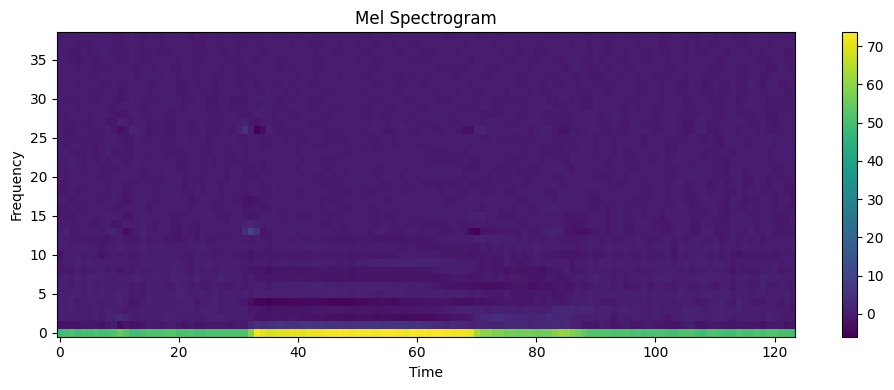

In [5]:
for mfccs, label in train.take(1):
    first_mfccs = mfccs[0]
    # # plot the first mel_spec in the batch
    plt.figure(figsize=(10, 4))
    plt.imshow(first_mfccs.numpy().T, origin="lower", aspect="auto")
    plt.colorbar()
    plt.title("Mel Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [6]:
import tensorflow as tf
from tensorflow import keras

In [7]:
#### hyper parameters that defines the structure of the model
num_classes = 31 # ds.get_labels()
sampled_frequencies = 129 # the number of frequency samples

learning_rate = 0.001
weight_decay = 0.005
batch_size = 64
num_epochs = 10000  # For real training, use num_epochs=100. 10 is a test value
# patch_size = 6  # Size of the patches to be extract from the input images
# num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 1
mlp_head_units = [
    526,
    256,
]  # Size of the dense layers of the final classifier


In [8]:
# from tc_resnet import TcResNet

In [9]:
# model = TcResNet(
#     num_blocks=4,
#     add_block_type_1_in_between=False,
#     kernel_size=9,
#     channels=[16, 24, 32, 48],
#     num_classes=31,
# )

# keras = tf.keras
# model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
#     filepath="./checkpoint/checkpoint.ckpt",
#     save_weights_only=True,
#     save_freq="epoch",
#     verbose=0,
# )
# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate),
#     loss="categorical_crossentropy",
#     metrics=["accuracy"],
# )

# model.fit(
#     train_ds.get_tf_dataset(1),
#     validation_data=valid_ds.get_tf_dataset(1),
#     epochs=num_epochs,
#     callbacks=[
#         model_checkpoint_callback,
#     ],
# )

In [10]:
import tensorflow as tf
from its_lru import StateTransformer

In [12]:
# Run both models TCResNet and StateTransformer for 30 epochs and graph the accuracy results
import matplotlib.pyplot as plt

state_transformer = StateTransformer(
    num_classes=31,
    num_heads=8,
    num_state_cells=10,
    input_seq_size=31,
    projection_dim=32,
    inner_ff_dim=64,
    dropout=0.1,
    kernel_regularizer=tf.keras.regularizers.l2(0.01),
)

state_transformer.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate / 2),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


model_path = "./models/its_chkpnt/its_chkpnt.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

In [13]:
state_transformer_history = state_transformer.fit(
    train,
    validation_data=valid,
    epochs=50,
    callbacks=[
        model_checkpoint_callback,
    ],
)


# tc_resnet = TCResNet(
#     num_blocks=3,
#     add_block_type_1_in_between=True,
#     kernel_size=9,
#     channels=[16, 24, 32, 48],
#     num_classes=31,
#     kernel_regularizer=tf.keras.regularizers.l2(0.01),
#     dropout=0.1,
# )

# tc_resnet.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate),
#     loss="categorical_crossentropy",
#     metrics=["accuracy"],
# )

# tc_resnet_history = tc_resnet.fit(
#     train,
#     validation_data=valid,
#     epochs=30,
#     # callbacks=[
#     #     model_checkpoint_callback,
#     # ],
# )

Epoch 1/50


2024-03-10 13:44:30.470577: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-10 13:44:30.496228: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7eff6800ae90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-10 13:44:30.496243: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-10 13:44:30.499213: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-10 13:44:30.594752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-10 13:44:30.656584: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

799/799 [==============================] - 74s 71ms/step - loss: 13.7720 - accuracy: 0.0833 - val_loss: 10.4419 - val_accuracy: 0.1700
Epoch 2/50
799/799 [==============================] - 59s 72ms/step - loss: 8.4523 - accuracy: 0.2226 - val_loss: 6.6912 - val_accuracy: 0.3195
Epoch 3/50
799/799 [==============================] - 58s 71ms/step - loss: 5.6321 - accuracy: 0.3871 - val_loss: 4.7063 - val_accuracy: 0.4567
Epoch 4/50
799/799 [==============================] - 58s 71ms/step - loss: 4.0411 - accuracy: 0.5321 - val_loss: 3.4452 - val_accuracy: 0.6026
Epoch 5/50
799/799 [==============================] - 59s 72ms/step - loss: 3.1123 - accuracy: 0.6210 - val_loss: 2.7697 - val_accuracy: 0.6685
Epoch 6/50
799/799 [==============================] - 59s 72ms/step - loss: 2.5613 - accuracy: 0.6718 - val_loss: 2.3477 - val_accuracy: 0.6876
Epoch 7/50
799/799 [==============================] - 58s 72ms/step - loss: 2.1818 - accuracy: 0.7101 - val_loss: 2.0708 - val_accuracy: 0.7078
E

In [ ]:
import string

In [ ]:
string.ascii_lowercase

In [ ]:
X = tf.random.normal([64, 129, 39])
tf.math.reduce_sum(X, axis=-1).shape

In [ ]:
# plot val accuracy
tc_resnet_history.history["val_accuracy"]
state_transformer_history.history["val_accuracy"]
plt.plot(tc_resnet_history.history["accuracy"], label="TCResNet")
plt.plot(state_transformer_history.history["accuracy"], label="StateTransformer")
plt.legend()
plt.show()

In [ ]:
tc_resnet.summary()

In [ ]:
state_transformer.summary()

In [ ]:
state_transformer_history.history["accuracy"]

In [ ]:
tc_resnet_history.history["accuracy"]

In [ ]:
linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=40,
        num_spectrogram_bins=129,
        sample_rate=16_000,
        lower_edge_hertz=0,
        upper_edge_hertz=8_000,
)

In [ ]:
# plot the mel filter
plt.figure(figsize=(10, 4))
plt.imshow(linear_to_mel_weight_matrix.numpy().T, aspect="auto")
plt.colorbar()
plt.title("Mel filter")
plt.xlabel("Frequency")
plt.ylabel("Mel bin")
plt.tight_layout()
plt.show()

In [ ]:
tf.one_hot(1, 31)

In [ ]:
16_000 // 2